# Data Visualization in Python 
DA Probability & Statistics Learning Series • Python Lesson 2

<img src="https://pyxis.nymag.com/v1/imgs/0c1/267/38d1f78b4d3b94bd1b630ed7f810f3504b-07-softbank-group-05.2x.rhorizontal.w700.jpg" align="center" height="400" width="600"/>

There's always something to learn from our fellow Vision Fund portfolio companies...

*See **#da_prob_stat** for discussion during and after this tutorial.*


## Goals

- Understand the basic tools available to visualize data in Python
- Create wrapper functions around existing visualization functions to make it easier to use them
- Learn to perfrom EDA with data viz in Python
- Give Shreyas a shot at being the TA he never was

## Setup ⚙️

In [412]:
# Import dependencies
from db_utils import get_connection, get_data
import pandas as pd
import numpy as np
import datetime

# Data viz
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure, axes
from matplotlib.ticker import PercentFormatter, FormatStrFormatter
import matplotlib.dates as mdates
import seaborn as sns

_Note that we are importing a new function called `get_data()` from `db_utils`. This is a wrapper around the the `pd.read_sql()` function you've seen before. Type `get_data()` and hit `Shift+Tab` to see how it works._

**WARM UP:** Complete `get_data()` function

def get_data(input_source, input_type, conn):
    """
    Function to get data from a .sql file or SQL query string input

    Parameters
    ---
    input_source
        Either a string with a valid SQL query or a .sql file

    input_type
        'file' if input is a .sql file; 'text' if input is  a string

    conn
        Connector object returned by get_connection() function
    """

    if input_type == 'text':
        # Use the read_sql method to get the data from Snowflake into a Pandas dataframe
        df = #pd.read(input_source, conn)

    if input_type == 'file':
        # Open the input_source file using the 'with' clause
        with #open(input_source, 'r') as q:

            # Save contents of input_source as a string in query_str
            query_str = #q.read()

            # Use the read_sql method to get the data from Snowflake into a Pandas dataframe
            df = #pd.read_sql(query_str, conn)

    # Make all the columns of the dataframe lowercase
    df.columns = map(str.lower, df.columns)

    return df

### Throwback ⏪

In the homework from the previous Python lesson, we calculated the OTP of Air shipments in March 2020

In [24]:
# Get the database connection and cursor objects
conn, cur = get_connection()

# Get data from the otp.sql file
hw_df = get_data('otp.sql', 'file', conn)

# Rename column headers
hw_df.columns = [
    'shipment_id', 
    'completion_date', 
    'mode_blended', 
    'transit_on_time', 
    'all_transit_milestones_completed'
]

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [25]:
# Create an int version of transit_on_time and convert completion date from string to date
hw_df['transit_on_time'] = hw_df['transit_on_time'].apply(lambda x: x == 'True')
hw_df['transit_on_time_int'] = hw_df['transit_on_time'].apply(lambda x: int(x))

hw_df['completion_dt'] = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in hw_df['completion_date']]
hw_df['completion_month'] = hw_df['completion_dt'].dt.month
hw_df['completion_year'] = hw_df['completion_dt'].dt.year

In [26]:
air_march_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['completion_month'] == 3) &
    (hw_df['completion_year'] == 2020) &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_march_otp.columns = ['mode', 'month', 'year', 'otp_percent']

print(f'Air Shipments OTP - March 2020: {air_march_otp.loc[0,"otp_percent"]*100}%')

Air Shipments OTP - March 2020: 36.0%


## Motivating Question 🤔

> What has OTP looked like for Air shipments over the course of 2020? Have things gotten better since Nate joined the team?

**TODO**: Create dataframe for overtime plot

In [27]:
air_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_otp.columns = ['mode', 'month', 'year', 'otp_percent']

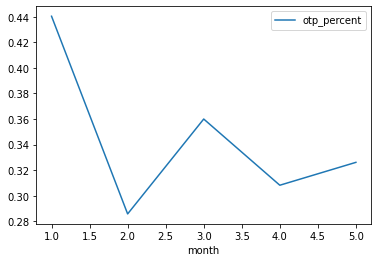

In [28]:
air_otp.plot('month', 'otp_percent')

And there's our first chart! It's not a pretty chart but it's a chart nonetheless... Also, Nate has evidently had a **HUGE** impact on the team in just a few months of being here.

### Open Questions ❓
- How does `.plot()` work?
- Shreyas can you **please** label your axes for me?
- Why does this chart look so 💩?

Let's dive in!

## Tools for Data Visualization 📈

> Great leaders don't blame the tools they are given. They work to sharpen them. - _Simon Sinek_

There are several tools we could use for data viz in Python, including `matplotlib`, `seaborn`, `plotly`, and `bokeh`. They're all quriky in their own ways though, and as analysts, we need to know how to make them work for us.

In this session, we will grapple with the the `matplotlib` package.

_Aside: I personally always get confused between `Module`, `Package`, and `Library`. Here's what the [internet](https://www.quora.com/What-is-the-difference-between-Python-modules-packages-libraries-and-frameworks) says:_
- **Module**: Any `.py` file that contains functions, Classes, global variables, etc. is considered a _module_. We've seen these before a lot: `pandas`, `numpy`, `datetime`, and even the custom created `db_utils` are all _modules_.
- **Package/Library**: In Python, these are synonymous. They are directories of other _packages/libraries_ and _modules_ that consolidate related tools and files in the same place. 
    - We can use the command `import library_name` to get all the _packages_ residing within `library_name`
    - We can also use the command `import library_name.module_name` or `from library_name import module_name` to access a specific _module_ in a _library_

## Matplotlib 📚

`matplotlib` is arguably the most popular and versatile visualization library in Python. It's built off `numpy` and is ideal for 2D plotting. It takes an object oriented approach to visualizing data, similar to how `pandas` uses object oriented methods to create tables.

In `pandas`, we instantiate an object of class `DataFrame` each time we want to create a table from a dictionary ro `csv` file or `sql` query. We then call functions on that object to manipulate and analyze the data.

In `matplotlib`, different classes are used to create different layers of a visualization. It's like drawing on a canvas! However, there are two fundamental ways in which you can use these classes to 'create your picture':
1. You can use an 'object oriented' approach by creating individual objects as you need them; **add to your canvas piece by piece**.
2. You can use convenience wrappers that automatically do some of the object creation *for you*; **start with a shell and go from there**.

We'll walk through both approaches.

### Matplotlib Strucutre 🧱

**Figure:** The base layer that contains one or more charts is called a `Figure`. If you are an artist, the `Figure` is your canvas.
- The `Figure` class lives in the module `matplotlib.figure`

In [91]:
## OBJECT ORIENTED

# Create an object of class figure
object_my_fig = figure.Figure(figsize=(4,4))
object_my_fig

<Figure size 288x288 with 0 Axes>

In [92]:
## PYPLOT WRAPPER

# More standard way of creating a figure using pyplot
fig = plt.figure(figsize=(4,4))

<Figure size 288x288 with 0 Axes>

**Axes:** A figure is nothing without the data we want to visualize - it's blank. Objects of class `Axes` contain the data we want to plot.
- `Axes` can be best thought of as, well, axes
- A figure can have multiple axes arranged in different ways
- Each `Axes` object is a chart that you want to plot
- You can provide an `Axes` object with a title, set the number of axis ticks, add a legend, choose the type of chart, and all that good stuff

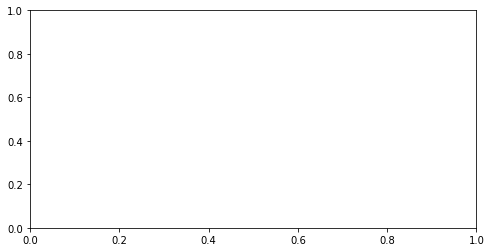

In [289]:
## OBJECT ORIENTED

# Recreating figure because we don't want to add an infinite number of axes to it each time we run this cell
object_my_fig = figure.Figure(figsize=(8,4))

# 1,1,1 says that you want to split the figure into 1 row and 1 column, and you want the axes at index 1
# Can also use add_axes(): takes a sequence of [left, bottom, width, height] quantities and fill the entire canvas
object_ax = object_my_fig.add_subplot(1,1,1)

object_my_fig

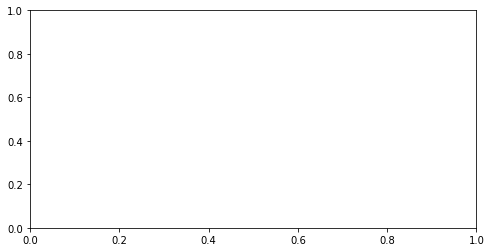

In [290]:
## PYPLOT WRAPPER

# Recreate figure to avoid adding too many axes
fig = plt.figure(figsize=(8,4))

# Add axes to figure using pyplot
# Can do this with plt.axes or plt.subplot
# .axes is a wrapper around fig.add_axes() and .subplot is a wrapper around fig.add_subplot()
# 1,1,1 says that you want to split the figure into 1 row and 1 column, and you want the axes at index 1

ax = plt.subplot(1, 1, 1)


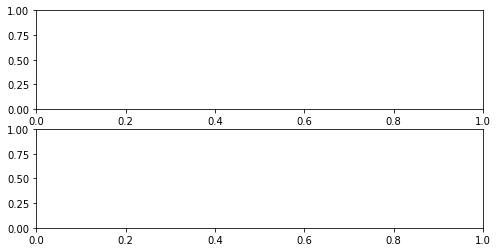

In [294]:
## TODO

# Recreate figure to avoid adding too many axes
fig = plt.figure(figsize=(8,4))

# Create 2 pairs of axes either stacked on top of, or adjacent to, each other
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

**Plot:** Now that you have the skeleton of your chart, you can start adding data to it!
- Charts can come in various forms, but for now, we will just stick with a basic line plot

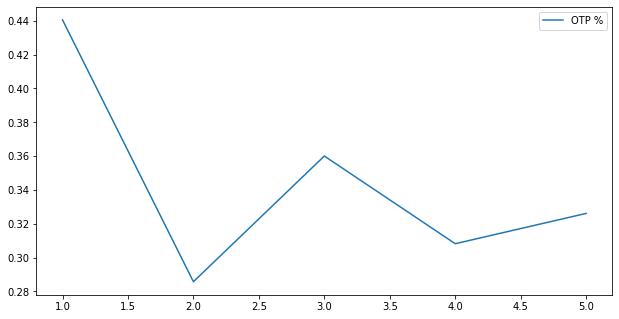

In [165]:
## OBJECT ORIENTED

# Recreate figure to avoid adding too many axes
object_my_fig = figure.Figure(figsize=(8,4))
object_ax = object_my_fig.add_axes([0,0,1,1])

# Plot OTP over time by calling .plot() on your axes object
object_ax.plot(air_otp['month'], air_otp['otp_percent'])

# Add a legend by calling .legend() with 'labels' on your axes object
object_ax.legend(labels=['OTP %'], loc=0)

# Display the figure
object_my_fig

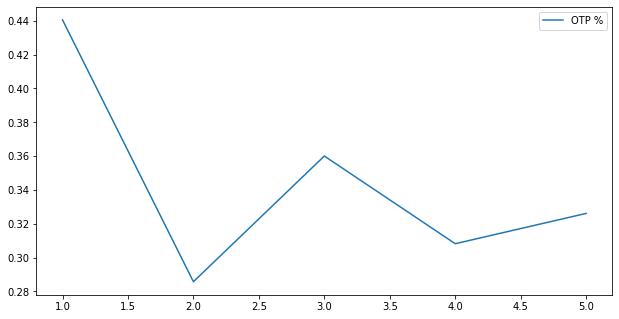

In [278]:
# PYPLOT WRAPPER

# Recreate figure to avoid adding too many axes
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(position=[0,0,1,1])

# Plot OTP over time by calling .plot() using plt
plt.plot(air_otp['month'], air_otp['otp_percent'])

# Add a legend by calling .legend() with 'labels' using plt
plt.legend(labels=['OTP %'], loc=0)

# Display the plot
plt.show()

In [279]:
## TODO



You might have already figured it out by now, but both `matplotlib.pyplot` and [`pandas.DataFrame.plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) are convenience wrappers around underlying `matplotlib` objects!

### Joining Forces 🔗

In reality, the `matplotlib` object-oriented paradigm and convenience wrappers don't function in isolation. Some wrappers help speed things up, and some `Axes` and `Figure` level functionality is necessary to create what you want.

Here are some high level steps to jazz up the chart a little.

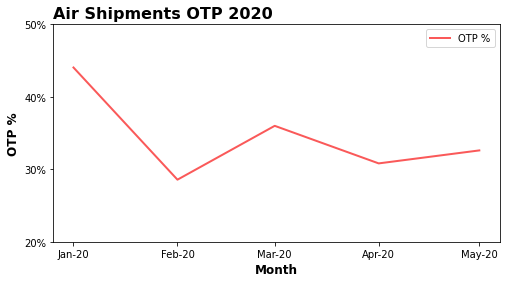

In [437]:
# Initialize 1 figure with one pair of axes together
# this is the same as fig, ax = plt.subplots(1, 1, figsize=(8,4))
fig1, ax1 = plt.subplots(figsize=(8,4))

# Format Fields
shipment_month = \
air_otp.apply(
    lambda x: datetime.datetime.strptime(str(x['month']) + '-' + str(x['year']), '%m-%Y'), 
    axis=1
)
otp_percent = air_otp['otp_percent']

# Plot
ax1.plot(shipment_month, otp_percent, label='OTP %', color='#FA5959', linewidth=2)

# Legend
ax1.legend(loc=0)

# Title
ax1.set_title(
    'Air Shipments OTP 2020', 
    loc='left', 
    fontdict = {'fontsize':16, 'fontweight':'bold'}
)

# Axis formatting
ax1.set_xlabel('Month', fontdict={'fontweight':'bold', 'fontsize':12})
ax1.set_ylabel('OTP %', fontdict={'fontweight':'bold', 'fontsize':12})
ax1.tick_params(axis='both', labelsize=10)

# X Ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%b-%y'))

# Y Ticks
ax1.yaxis.set_ticks(
    np.linspace(
        np.round(min(otp_percent) - (0.2*min(otp_percent)), 1), 
        np.round(max(otp_percent) + (0.1*max(otp_percent)), 1),
        num=4
    )
)

ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0)) # xmax is the max percent

# Show plot
plt.show()